In [48]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from collections import namedtuple
from random import sample, shuffle
from functools import reduce
from math import sqrt, ceil, floor, log, pi

from tensorflow.keras import layers, losses, models as mds, optimizers, utils

In [39]:
# Dataset image size
IMG_SIZE = 264
N_CLASSES = 102

def preprocess(image, *args):
    image = tf.image.resize_with_pad(image, IMG_SIZE, IMG_SIZE)
    image /= 255
    return (image, *args)

train_ds, val_ds = tfds.load(
    'oxford_flowers102',
    split=['train[:20%]', 'validation'],
    as_supervised=True,
    read_config=tfds.ReadConfig(try_autocache=False)
)

train_ds = train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

In [95]:
LEARNING_RATE = 0.1

def conv_block(x, filters, strides, padding, activation):
    kwargs = dict(strides=strides, padding=padding)
    layer = tf.keras.Sequential([
        layers.Conv2D(filters, 3, **kwargs),
        layers.BatchNormalization(),
        layers.Activation(activation),
#         layers.Dropout(.65)
    ])
    
    return layer(x)

def variant_dims(size):
    n_variants = ceil(log(ceil(sqrt(size)), pi))
    return list(map(lambda x: 3**x, range(1, n_variants+1)))

def sic_block(input_tensor, filters, strides, padding, activation):
    def make_layer(size):
        kwargs = dict(strides=strides, padding=padding)
        return layers.Conv2D(filters, size, **kwargs)

    size = min(input_tensor.shape[1:-1])
    variants = variant_dims(size)
    conv_layers = map(make_layer, variants)
    conv_outputs = list(map(lambda x: x(input_tensor), conv_layers))
    merged = tf.concat(conv_outputs, axis=-1)
    normalized = layers.BatchNormalization()(merged)
    output = layers.Activation(activation)(normalized)
#     reg_output = layers.Dropout(.65)(output)

    return output

def sidsc_block(input_tensor, filters, strides, padding, activation):
    def make_layer(size):
        kwargs = dict(strides=strides, padding=padding)
        return layers.DepthwiseConv2D(size, **kwargs)

    size = min(input_tensor.shape[1:-1])
    variants = variant_dims(size)
    sidsc_layers = map(make_layer, variants)
    
    x = list(map(lambda x: x(input_tensor), sidsc_layers))
    x = tf.math.add_n(x)
    x = layers.MaxPool2D(variants[0], 1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    
    # Channel Expansion
    kwargs = dict(strides=1, padding=padding, activation=activation)
    output = layers.Conv2D(filters, variants[0], **kwargs)(x)
#     reg_output = layers.Dropout(.65)(output)

    return output

def sicwc_block(input_tensor, filters, strides, padding, activation):
    def make_layer(size):
        def make_channel_conv(_):
            kwargs = dict(strides=strides, padding=padding, activation=activation)
            return layers.Conv2D(1, size, **kwargs)

        inp = tf.keras.Input(shape=input_tensor.shape[1:])
        channel_convs = list(map(make_channel_conv, range(inp.shape[-1])))
        channels = tf.split(inp, len(channel_convs), axis=-1)
        channel_outputs = [l(channels[i]) for i,l in enumerate(channel_convs)]
        output = tf.concat(channel_outputs, axis=-1)
        cwc_layer = tf.keras.Model(inp, output)

        return cwc_layer

    size = min(input_tensor.shape[1:-1])
    variants = variant_dims(size)
    sicwc_layers = map(make_layer, variants)
    
    x = list(map(lambda x: x(input_tensor), sicwc_layers))
    x = tf.math.add_n(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    
    # Channel Expansion
    kwargs = dict(strides=1, padding=padding, activation=activation)
    output = layers.Conv2D(filters, variants[0], **kwargs)(x)
#     reg_output = layers.Dropout(.65)(output)

    return output

def sicpc_block(input_tensor, filters, strides, padding, activation):
    def make_layer(size):
        kwargs = dict(strides=strides, padding=padding, activation=activation)
        return layers.Conv2D(input_tensor.shape[-1], size, **kwargs)

    size = min(input_tensor.shape[1:-1])
    variants = variant_dims(size)
    sicpc_layers = map(make_layer, variants)
    
    x = list(map(lambda x: x(input_tensor), sicpc_layers))
    x = tf.math.add_n(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    
    # Channel Expansion
    kwargs = dict(strides=1, padding=padding, activation=activation)
    output = layers.Conv2D(filters, variants[0], **kwargs)(x)
#     reg_output = layers.Dropout(.65)(output)

    return output

def siwrc_block(input_tensor, filters, strides, padding, activation):
    def wc_block():
        pass

    def rc_block():
        pass

    def make_layer(size):
        kwargs = dict(strides=strides, padding=padding, activation=activation)
        return layers.Conv2D(input_tensor.shape[-1], size, **kwargs)

    size = min(input_tensor.shape[1:-1])
    variants = variant_dims(size)
    sicpc_layers = map(make_layer, variants)
    
    x = list(map(lambda x: x(input_tensor), sicpc_layers))
    x = tf.math.add_n(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    
    # Channel Expansion
    kwargs = dict(strides=1, padding=padding, activation=activation)
    output = layers.Conv2D(filters, variants[0], **kwargs)(x)
#     reg_output = layers.Dropout(.65)(output)

    x = wc_block()(input_tensor)
    x = rc_block()(input_tensor)

    return x

def sic_specs():
    return [(8, 2), (16, 1), (32, 2), (32, 1), (64, 2), (64, 1), (128, 2), (256, 2)]
    
def conv_specs():
    return [(32, 2), (64, 1), (128, 2), (128, 1), (256, 2), (256, 1),
        (512, 2), (512, 1), (512, 1), (512, 1), (512, 1), (512, 1), (1024, 2)]

def sidsc_specs():
    return [(32, 2), (64, 1), (128, 2), (128, 1), (256, 2), (256, 1), (512, 2), (512, 1), (1024, 2)]

def sicwc_specs():
    # return [(32, 2), (64, 1), (128, 2), (128, 1), (256, 2), (256, 1), (512, 2), (512, 1), (1024, 2)]
    return [(32, 2), (16, 1), (128, 2), (32, 1), (256, 2), (64, 1), (512, 2)]

def sicpc_specs():
    return [(32, 2), (64, 1), (128, 2), (128, 1), (256, 2), (256, 1),
        (512, 2), (512, 1), (512, 1), (512, 1), (512, 1), (512, 1), (1024, 2)]

def siwrc_specs():
    return [(32, 2), (128, 2), (256, 2), (512, 2), (1024, 2)]

def create_model(conv_type=None):
    def conv_fn(x, y):
        args = [x, y[0], y[1], 'same', 'relu']

        if conv_type == 'sic':
            return sic_block(*args)
        elif conv_type == 'sidsc':
            return sidsc_block(*args)
        elif conv_type == 'sicwc':
            return sicwc_block(*args)
        elif conv_type == 'sicpc':
            return sicpc_block(*args)
        else:
            return conv_block(*args)
    
    def spec_fn():
        if conv_type == 'sic':
            return sic_specs()
        elif conv_type == 'sidsc':
            return sidsc_specs()
        elif conv_type == 'sicwc':
            return sicwc_specs()
        elif conv_type == 'sicpc':
            return sicpc_specs()
        else:
            return conv_specs()
        
    inp = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    specs = spec_fn()

    x = reduce(conv_fn, specs, inp)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(floor(N_CLASSES/2))(x)
    output = layers.Dense(N_CLASSES, activation='softmax')(x)

    model = tf.keras.Model(inputs=inp, outputs=output)
    optimizer = optimizers.Nadam()
#     optimizer = optimizers.Adadelta(learning_rate=LEARNING_RATE)
    loss = 'sparse_categorical_crossentropy'

    model.compile(optimizer=optimizer, loss=loss, metrics='accuracy')
    
    return model

model = create_model(conv_type='sicpc')
# model = create_model(conv_type='sicwc')
# model = create_model(conv_type='sidsc')
# model = create_model(conv_type='sic')
# model = create_model()
model.summary()

Model: "model_143"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_169 (InputLayer)         [(None, 264, 264, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_15289 (Conv2D)          (None, 132, 132, 3)  84          ['input_169[0][0]']              
                                                                                                  
 conv2d_15290 (Conv2D)          (None, 132, 132, 3)  732         ['input_169[0][0]']              
                                                                                                  
 conv2d_15291 (Conv2D)          (None, 132, 132, 3)  6564        ['input_169[0][0]']      

In [93]:
# utils.plot_model(model, to_file='model.png', show_shapes=True)
itr = iter(train_ds)
[next(itr) for i in range(10)];

image, _ = next(itr)
image


<tf.Tensor: shape=(264, 264, 3), dtype=float32, numpy=
array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)>

In [84]:
from matplotlib import pyplot as plt

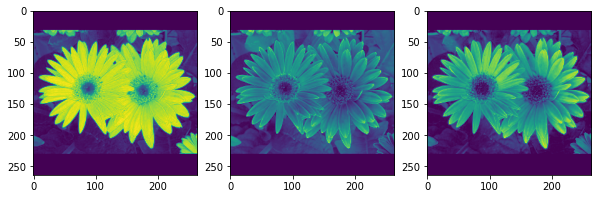

In [94]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5))

ax[0].imshow(image[..., 0])
ax[1].imshow(image[..., 1])
ax[2].imshow(image[..., 2])

# plt.imshow(image[..., 0])
